# Linear Regression Implementation from Scratch

Cài đặt và khai báo thư viện:


In [ ]:
!pip install d2l==0.15.1


In [2]:
%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf
import random

## Generating the Dataset

Để đơn giản, ta sẽ tạo mô hình tuyến tính với nhiễu cộng và dữ liệu ít chiều để dễ mô hình hoá.

* Ma trận $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
* Weight: $\mathbf{w} = [2, -3.4]^\top$
* Bias: $b = 4.2$
* Noise: $\epsilon$ tuân theo phân phối chuẩn với giá trị trung bình mean = 0 và độ lệch chuẩn = 0.01
* $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$


In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    # Tạo một ma trận không có num_examples dòng và số cột là số dòng của vector weight
    X = tf.zeros((num_examples, w.shape[0]))
    # Lấy ma trận không cộng với ma trận được tạo ngẫu nhiên từ phân phối chuẩn có mean = 0 với kích thước bằng với kích thước của ma trận không
    X += tf.random.normal(shape=X.shape)
    # Chuyển vị vector weight thành vector cột rồi lấy ma trận X đã tạo ở trên nhân với vector weight này sau đó đem cộng với bias 
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    # Tạo noise ngẫu nhiên tuân theo phân phối chuẩn với giá trị trung bình = 0 và độ lệch chuẩn = 0.01 rồi cộng với y
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    # Chuyển vị vector y thành vector cột
    y = tf.reshape(y, (-1, 1))
    # Trả về X, y là features và labels tương ứng
    return X, y

In [7]:
# Tạo một vector dòng trọng số weights đúng cho các features
true_w = tf.constant([2, -3.4])
# Khởi tạo giá trị bias đúng
true_b = 4.2
# Tạo dữ liệu (features, labels) dựa trên các tham số là true_w, true_b và số lượng mẫu là 1000
features, labels = synthetic_data(true_w, true_b, 1000)

In [8]:
# In ra sample đầu tiên của dataset 
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([ 0.38850188 -0.89063424], shape=(2,), dtype=float32) 
label: tf.Tensor([7.9946394], shape=(1,), dtype=float32)


Mô hình hoá dữ liệu:

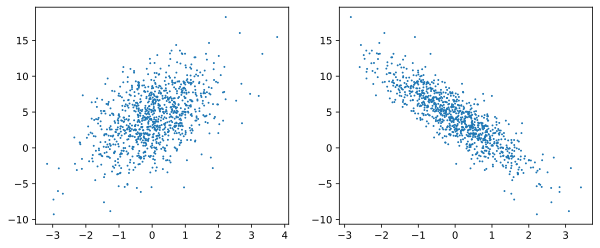

In [9]:
# Thiết lập kích thước đồ thị 
d2l.set_figsize((10,4))
# Tạo đồ thị phân tán với trục x là các giá trị cột thứ 1 của features và trục y là giá trị của labels  
d2l.plt.subplot(1,2,1)
d2l.plt.scatter(d2l.numpy(features[:, 0]), d2l.numpy(labels), 1)
# Tạo đồ thị phân tán với trục x là các giá trị cột thứ 2 của features và trục y là giá trị của labels
d2l.plt.subplot(1,2,2) 
d2l.plt.scatter(d2l.numpy(features[:, 1]), d2l.numpy(labels), 1)
# Hiển thị đồ thị
d2l.plt.show()

## Reading the Dataset

Để train models, ta sẽ chia nhỏ tập dữ liệu và chỉ lấy một minibatch mỗi lần để cập nhật lại model. Do đó ta cần phải xáo dữ liệu cho mỗi lần chạy. Hàm `data_iter` bên dưới sẽ dựa vào kích thước của batch, ma trận features và vector labels để tạo ra minibatch.


In [10]:
def data_iter(batch_size, features, labels):
    # Khởi tạo lại số lượng mẫu chính là số dòng của features
    num_examples = len(features)
    # Tạo một danh sách chỉ số cho các examples 
    indices = list(range(num_examples))
    # Sắp xếp ngẫu nhiên các chỉ số để có thể lấy mẫu một cách ngẫu nhiên 
    random.shuffle(indices)
    # Dùng vòng lặp duyệt qua số lượng examples với bước nhảy là kích thước minibatches  
    for i in range(0, num_examples, batch_size):
        # Tạo một danh sách các chỉ số mẫu cần lấy cho mỗi minibatch tương ứng với kích thước minibatches
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        # Lấy các features và labels tương ứng với các chỉ số và trả về từng minibatch
        yield tf.gather(features, j), tf.gather(labels, j)

In [11]:
# Khởi tạo kích thước minibatch là 10
batch_size = 10
# In ra minibatch đầu tiên
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[-0.43953738 -0.0949278 ]
 [-0.96092486 -0.11567789]
 [ 1.0815861   0.3875196 ]
 [-0.4563365   0.40175036]
 [ 1.0132185   1.2109225 ]
 [ 0.31520516 -0.61363465]
 [-1.5530571  -0.7675695 ]
 [-0.30114114 -0.13614704]
 [-0.00187851  1.0574087 ]
 [-0.789788    0.15474631]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[3.6232274 ]
 [2.6712263 ]
 [5.05766   ]
 [1.917116  ]
 [2.117969  ]
 [6.912935  ]
 [3.7004688 ]
 [4.050587  ]
 [0.60551643]
 [2.0953743 ]], shape=(10, 1), dtype=float32)


## Initializing Model Parameters

Khởi tạo giá trị cho weight bằng cách lấy ngẫu nhiên giá trị từ phân phối chuẩn với giá trị trung bình = 0 và độ lệch chuẩn = 0.01. Khởi tạo giá trị cho bias bằng 0.

In [12]:
# Khởi tạo vector weight với các giá trị ngẫu nhiên tuân theo phân phối chuẩn có giá trị trung bình là 0 và độ lệch chuẩn là 0.01
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),trainable=True)
# Khởi tạo bias = 0
b = tf.Variable(tf.zeros(1), trainable=True)

## Defining the Model

Đưa ra mô hình hồi quy tuyến tính: $\hat{\mathbf{y}} = \mathbf{X} \mathbf{w} + b$

In [13]:
# Mô hình hồi quy tuyến tính theo công thức y^ = Xw + b
def linreg(X, w, b):
    return tf.matmul(X, w) + b

## Defining the Loss Function


In [14]:
# Hàm mất mát l(w,b) = 1/2 * (y_hat - y)^2
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

## Defining the Optimization Algorithm

Tại mỗi bước, ta sẽ ước lượng gradient của hàm loss theo từng tham số bằng cách sử dụng một minibatch ngẫu nhiên từ tập dữ liệu. Sau đó ta sẽ cập nhật lại tham số theo hướng làm giảm sự mất mát $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$. Kích thước của bước cập nhật chính là tốc độ học `lr`.


In [15]:
# Minibatch stochastic gradient descent
def sgd(params, grads, lr, batch_size):
    # Với mỗi tham số và gradient tương ứng trong bộ các tham số và gradient 
    for param, grad in zip(params, grads):
        # Cập nhật lại tham số (w,b) bằng cách trừ đi gradient * learning rate / kích thước minibatch
        param.assign_sub(lr*grad/batch_size)

## Training

Với mỗi lần chạy, ta lấy một minibatch từ training examples rồi đưa vào mô hình. Tiếp đó, ta tính mất mát của mô hình ứng với từng minibatch, tính gradient của hàm loss theo weight và bias rồi cập nhật lại giá trị của weight và bias dựa trên gradient này.

* Khởi tạo tham số $(\mathbf{w}, b)$
* Lặp lại cho đến khi duyệt hết các minibatch
    * Tính gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Cập nhật tham số $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


In [16]:
# learning rate 
lr = 0.03
# Số lần chạy 
num_epochs = 3
# Đổi tên hàm tương ứng
net = linreg
loss = squared_loss

In [17]:
# Lặp cho mỗi lần chạy
for epoch in range(num_epochs):
    # Duyệt qua features và labels tương ứng trong mỗi minibatch 
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            # Tính loss cho mô hình với dữ liệu của minibatch
            l = loss(net(X, w, b), y)
        # Tính gradient của loss lần lượt theo weight và theo bias 
        dw, db = g.gradient(l, [w, b])
        # Cập nhật lại weight và bias dựa trên gradient
        sgd([w, b], [dw, db], lr, batch_size)
    # Tính loss cho mô hình với (w,b) sau khi đã được cập nhật tối ưu qua các minibatch 
    train_l = loss(net(features, w, b), labels)
    # In ra giá trị trung bình loss tương ứng với mỗi lần chạy 
    print(f'Epoch {epoch + 1}: loss {float(tf.reduce_mean(train_l)):f}')

Epoch 1: loss 0.042909
Epoch 2: loss 0.000161
Epoch 3: loss 0.000050


Do dữ liệu được tạo ra từ weight và bias đã cho nên ta có thể kiểm tra lại mô hình train có thành công không bằng cách so sánh giá trị weight và bias dự đoán với giá trị đã cho.


In [18]:
# In ra w true và w predicted
print(f'w true: {true_w}')
print(f'w predicted: {tf.reshape(w, true_w.shape).numpy()}')
# In ra b true và b predicted
print(f'b true: {true_b}')
print(f'b predicted: {b.numpy()}')
# In ra độ lỗi giữa tham số đã cho và tham số ước lượng
print(f'error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

w true: [ 2.  -3.4]
w predicted: [ 1.9998012 -3.3998437]
b true: 4.2
b predicted: [4.1996593]
error in estimating w: [ 0.00019884 -0.0001564 ]
error in estimating b: [0.00034046]
